In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# ============================================================
#                 VARIABLES PRINCIPALES (EDITABLES)
# ============================================================

inversion_inicial = 1_000_000            # Ahorro inicial
aporte_mensual_inicial = 100_000         # Aporte mensual en el año 1
crecimiento_aporte_anual = 0.06          # 6% de aumento del aporte al año

años_simulacion = [1, 5, 10, 20]         # Años a simular
simulaciones = 1000                      # Número de escenarios Monte Carlo

# Supuestos del SP500 (VOO)
retorno_acciones = 0.10                  # 10% anual
volatilidad_acciones = 0.15              # 15%
costo_voi = 0.0007                       # 0.07% costos

# Supuestos de renta fija en COP
retorno_renta_fija = 0.08                # 8% anual (Lulo Bank)
volatilidad_renta_fija = 0.001           # casi cero
correlacion = 0.0                        # renta fija vs acciones

# Pesos de tu portafolio
peso_renta_fija = 0.60                   # 35% renta fija + 25% emergencia
peso_acciones = 0.40

In [3]:
# ============================================================
#      FUNCIÓN PARA CALCULAR EL APORTE MENSUAL CON AUMENTO
# ============================================================

def aporte_mensual_con_crecimiento(mes):
    año_actual = mes // 12
    return aporte_mensual_inicial * ((1 + crecimiento_aporte_anual) ** año_actual)

In [4]:
# ============================================================
#                 SIMULACIÓN 100% VOO
# ============================================================

def simular_voo(años):
    meses = años * 12

    retorno_mensual = (1 + retorno_acciones - costo_voi)**(1/12) - 1
    volatilidad_mensual = volatilidad_acciones / np.sqrt(12)

    valores_finales = []

    for _ in range(simulaciones):
        valor = inversion_inicial

        for mes in range(meses):
            rendimiento = np.random.normal(retorno_mensual, volatilidad_mensual)
            aporte = aporte_mensual_con_crecimiento(mes)
            valor = valor * (1 + rendimiento) + aporte

        valores_finales.append(valor)

    return np.array(valores_finales)

In [5]:
# ============================================================
#             SIMULACIÓN TU PORTAFOLIO (60% FIJO, 40% ACC)
# ============================================================

def simular_tu_portafolio(años):
    meses = años * 12

    # Rentabilidad renta fija
    ret_rf_mensual = (1 + retorno_renta_fija)**(1/12) - 1
    vol_rf_mensual = volatilidad_renta_fija / np.sqrt(12)

    # Rentabilidad acciones
    ret_acc_mensual = (1 + retorno_acciones)**(1/12) - 1
    vol_acc_mensual = volatilidad_acciones / np.sqrt(12)

    # Matriz de varianza-covarianza
    cov = correlacion * vol_rf_mensual * vol_acc_mensual
    matriz_cov = [[vol_rf_mensual**2, cov],
                  [cov, vol_acc_mensual**2]]

    valores_finales = []

    for _ in range(simulaciones):
        valor = inversion_inicial

        for mes in range(meses):
            ret_rf, ret_acc = np.random.multivariate_normal(
                mean=[ret_rf_mensual, ret_acc_mensual],
                cov=matriz_cov
            )

            rendimiento_portafolio = (
                peso_renta_fija * ret_rf +
                peso_acciones * ret_acc
            )

            aporte = aporte_mensual_con_crecimiento(mes)
            valor = valor * (1 + rendimiento_portafolio) + aporte

        valores_finales.append(valor)

    return np.array(valores_finales)

In [6]:
# ============================================================
#                EJECUTAR SIMULACIÓN
# ============================================================

resultados = []

for años in años_simulacion:
    valores_voo = simular_voo(años)
    valores_tuyo = simular_tu_portafolio(años)

    resultados.append({
        "años": años,

        "VOO_promedio": np.mean(valores_voo),
        "VOO_p10": np.percentile(valores_voo, 10),
        "VOO_p90": np.percentile(valores_voo, 90),

        "TU_promedio": np.mean(valores_tuyo),
        "TU_p10": np.percentile(valores_tuyo, 10),
        "TU_p90": np.percentile(valores_tuyo, 90),
    })

df = pd.DataFrame(resultados)

In [7]:
pd.set_option('display.float_format', lambda x: f'{x:,.0f}')
df

,años,VOO_promedio,VOO_p10,VOO_p90,TU_promedio,TU_p10,TU_p90
0,1,"2,360,644","2,046,131","2,696,391","2,336,564","2,210,906","2,462,187"
1,5,"10,176,102","7,482,977","13,265,683","9,828,471","8,798,748","10,939,873"
2,10,"27,548,866","17,989,559","40,114,729","26,088,387","22,353,504","30,187,161"
3,20,"114,845,327","62,235,955","179,877,866","103,439,654","82,711,667","126,023,937"


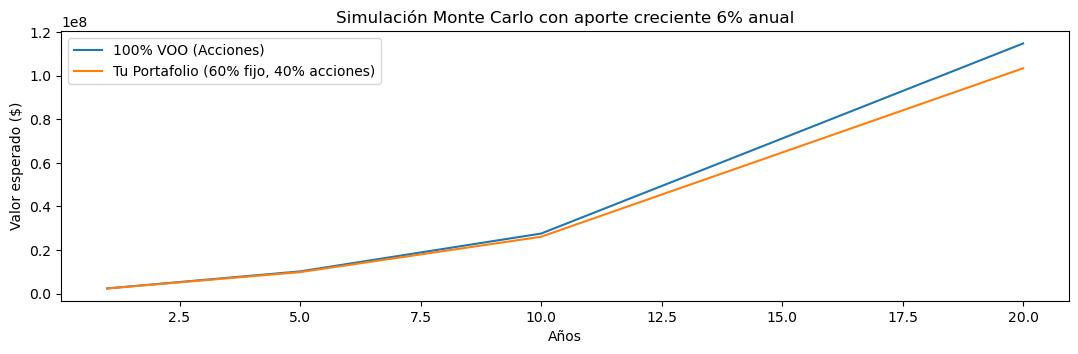

In [12]:
# COMPARACIÓN

plt.figure(figsize=(13,3.5))
plt.plot(df["años"], df["VOO_promedio"], label="100% VOO (Acciones)")
plt.plot(df["años"], df["TU_promedio"], label="Tu Portafolio (60% fijo, 40% acciones)")
plt.xlabel("Años")
plt.ylabel("Valor esperado ($)")
plt.title("Simulación Monte Carlo con aporte creciente 6% anual")
plt.legend();